In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%%capture
%autoreload 2
from nih_topics import get_nih_projects
from cordis_topics import get_cordis_projects
from crunchbase_topics import get_crunchbase_orgs
from arxiv_topics import get_arxiv_articles

from indicators.core.nlp_utils import parse_corex_topics
import pandas as pd
from datetime import datetime as dt
from functools import partial
from skbio.diversity.alpha import shannon

In [9]:
def get_objects_and_labels(data_getter, topic_model_path):
    print("Getting data")
    _objects = data_getter()
    print("Converting to DF")
    objects = pd.DataFrame(_objects)
    print("Parsing topics")
    topics = parse_corex_topics(topic_model_path.format("topics.txt"))
    print("Parsing labels")
    labels = pd.read_csv(topic_model_path.format("labels.txt"), names=topics, index_col=0)
    print("Subsetting topics")
    total_correlation = pd.read_csv(topic_model_path.format("most_deterministic_groups.txt"))
    is_fluffy = total_correlation[" NTC"].apply(lambda x: abs(x) < 0.02)
    fluffy_topics = [topics[itopic] for itopic in total_correlation['Group num.'].loc[is_fluffy]]                     
    non_stop_topics = pd.Series(topics,index=topics)[(labels.mean(axis=0) < 0.3)].values.tolist()
    antitopics = [t for t in topics if t.count("~") >= 3]
    labels = labels[(set(non_stop_topics) - set(antitopics)) - set(fluffy_topics)]
    return objects, labels

def total_activity_by_topic_in_date_range(objs, labels, datefield, norm_days, from_date='2020-03-01', to_date=dt.now()):
    _date = objs[datefield]
    total_days = (pd.to_datetime(to_date) - pd.to_datetime(from_date)).days
    norm = norm_days / total_days
    slicer = (_date > pd.to_datetime(from_date)) & (_date < pd.to_datetime(to_date))
    activity = labels[slicer].sum(axis=0).sort_values()
#     print()
#     print(norm)
#     print("=======")
#     print(activity)
    return norm * activity


def thematic_diversity(objs, labels, datefield, covid_slicer, from_date='2020-03-01'):
    _date = objs[datefield]
    date_slicer = _date > pd.to_datetime(from_date)
    thematic_diversity_covid = shannon(labels.loc[date_slicer & covid_slicer].sum(axis=0))
    thematic_diversity_noncovid = shannon(labels.loc[date_slicer & ~covid_slicer].sum(axis=0))
    return thematic_diversity_covid, thematic_diversity_noncovid

In [10]:
def covid_filterer(item):
    return any(term in item for term in
               ['covid', 'covid-19', 'coronavirus'])

def generate_indicators(data_getter, topic_model_path, datefield, old_from_date, old_to_date, covid_start, weight_field=None):
    covid_end = dt.now()
    norm_days = (pd.to_datetime(covid_end) - pd.to_datetime(covid_start)).days
    objects, topic_labels = get_objects_and_labels(data_getter, topic_model_path)
    
    # Apply filter to data based on topic labels and date
    print("Generating indicators")
    covid_label = list(filter(covid_filterer, topic_labels))[0]
    slicer = topic_labels[covid_label] == 1
    weight = 1 if weight_field is None else objects[weight_field]
    topic_labels = topic_labels.multiply(weight, axis=0)
    get_total_activity_all = partial(total_activity_by_topic_in_date_range, objects, topic_labels, datefield, norm_days)
    get_total_activity_cov = partial(total_activity_by_topic_in_date_range, objects.loc[slicer], topic_labels.loc[slicer], datefield, norm_days)
    get_total_activity_noncov = partial(total_activity_by_topic_in_date_range, objects.loc[~slicer], topic_labels.loc[~slicer], datefield, norm_days)
    old_dates = dict(from_date=old_from_date, to_date=old_to_date)

    indicators = {}

    # Levels of activity by topic, total (2020)
    print("Total activity")
    indicators["total_activity"] = get_total_activity_all()

    # Levels of activity by topic, relative to the average from 2015-2019
    print("Relative activity")    
    _norm_past_activity = get_total_activity_all(**old_dates)
    indicators["relative_activity"] = indicators["total_activity"] / _norm_past_activity

    # Levels of activity by topic, relative to the average from 2015-2019, covid tagged
    print("Relative Covid")        
    _total_activity = get_total_activity_cov()
    _norm_past_activity = get_total_activity_cov(**old_dates)
    indicators["relative_activity_covid"] = _total_activity / _norm_past_activity

    # Levels of activity by topic, relative to the average from 2015-2019, non-covid tagged
    print("Relative Non-Covid")            
    _total_activity = get_total_activity_noncov()
    _norm_past_activity = get_total_activity_noncov(**old_dates)
    indicators["relative_activity_noncovid"] = _total_activity / _norm_past_activity

    # Overrepresentation (activity) of covid tagged compared to non-covid tagged projects 
    indicators["overrepresentation_activity"] = indicators["relative_activity_covid"] / indicators["relative_activity_noncovid"]

    # Thematic diversity (activity) of co-occurring topics of covid tagged compared to non-covid tagged projects
    print("Diversity")                
    thematic_diversity_covid, thematic_diversity_noncovid = thematic_diversity(objects, topic_labels, 
                                                                               datefield, slicer)
    indicators["thematic_diversity_covid"] = thematic_diversity_covid
    indicators["thematic_diversity_noncovid"] = thematic_diversity_noncovid
    
    return indicators #, objects.loc[slicer], topic_labels.loc[slicer]

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm

def make_parallels(activity):
    parallels = defaultdict(list)
    indicator_names = []
    for indicator_name, indicators in activity.items():
        if indicator_name.startswith('thematic_diversity'):
            continue
        if indicator_name == 'relative_activity_noncovid':
            continue            
        indicator_names.append(indicator_name)        
        for i, (topic, value) in enumerate(indicators.sort_values().items()):
            score = i/len(indicators)
            parallels[topic].append(score)
    return indicator_names, parallels

def make_parallel_plot(activity, dataset, entity_type, activity_type='activity'):
    cmap = cm.get_cmap('cividis')
    verbose_indicator_names = {'total_activity': f'Total {activity_type} of topic\nsince March 2020',
                               'relative_activity': f'{activity_type.title()} of topic since March 2020,\nrelative to expectation of 2015-2019',
                               'relative_activity_covid': f'{activity_type.title()} of topic since March 2020,\nrelative to expectation of 2015-2019,\nof projects also tagged by Covid topic',
                               'overrepresentation_activity': f'Overrepresentation (in terms of {activity_type.title()})\nof this topic in Covid-tagged projects'}

    indicator_names, parallels = make_parallels(activity)
    indicator_names = [verbose_indicator_names[name] for name in indicator_names]
    
    # Remove topics which are too prevalent ("stop topics") (first element, v[0] is 'total_activity')
    parallels = {k: v for k, v in parallels.items() if v[0] < 0.95 and v[0] > 0.05}
    
    df = pd.DataFrame(parallels, index=indicator_names).T.reset_index()
    df['Topic'] = df['index']
    del df['index']
    
    fig, ax = plt.subplots(figsize=(12,15))
    order = [coords[-1] for coords in parallels.values()]
    pd.plotting.parallel_coordinates(df, 'Topic', ax=ax, color=map(cmap, order))
    handles, labels = ax.get_legend_handles_labels()
    labels, handles, _ = zip(*sorted(zip(labels, handles, order), key=lambda t: -t[2]))
    legend = ax.legend(handles, labels, bbox_to_anchor=(1.2, 1.05), title='Topics')
    legend.get_title().set_fontsize(20)
    ax.set_xlabel('Indicator name', fontsize=20)
    ax.set_ylabel('Ranking of indicator', fontsize=20)
    ax.set_title(f"Topic composition of {entity_type.title()}\nDataset: {dataset.title()}\nIndicator of: {activity_type.title()} levels", fontsize=25)
    return ax

def make_diversity_plot(diversities):
    fig, ax = plt.subplots(figsize=(10,12))

    cmap = cm.get_cmap('Set2')
    tick_locations = []
    for i, (dataset, (ymin, ymax)) in enumerate(diversities.items()):
        tick_locations.append(i+0.5)
        ax.vlines(i+0.5, ymin, ymax, colors='k', linestyles='--')
        if i == 0:
            ax.scatter(i+0.5, ymin, s=100, color=cmap(1), label='Covid-tagged')
            ax.scatter(i+0.5, ymax, s=100, color=cmap(2), label='Non-covid-tagged')
        else:
            ax.scatter(i+0.5, ymin, s=100, color=cmap(1))
            ax.scatter(i+0.5, ymax, s=100, color=cmap(2))        
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(diversities.keys(), fontsize=20)
    ax.set_ylabel('Topic diversity of data', fontsize=20)
    ax.set_xlabel('Dataset', fontsize=30)
    ax.legend(fontsize=20)
    return ax

Doing cordis
Getting data
Converting to DF
Parsing topics
Parsing labels
Subsetting topics
Generating indicators
Total activity
Relative activity
Relative Covid
Relative Non-Covid
Diversity
Making parallel plot
Getting data
Converting to DF
Parsing topics
Parsing labels
Subsetting topics
Generating indicators
Total activity
Relative activity
Relative Covid
Relative Non-Covid
Diversity
Doing nih
Getting data
Converting to DF
Parsing topics
Parsing labels
Subsetting topics
Generating indicators
Total activity
Relative activity
Relative Covid
Relative Non-Covid
Diversity
Making parallel plot
Getting data
Converting to DF
Parsing topics
Parsing labels
Subsetting topics
Generating indicators
Total activity
Relative activity
Relative Covid
Relative Non-Covid
Diversity
Doing arxiv
Getting data
Converting to DF
Parsing topics
Parsing labels
Subsetting topics
Generating indicators
Total activity
Relative activity
Relative Covid
Relative Non-Covid
Diversity
Making parallel plot


NameError: name 'make_diversity_map' is not defined

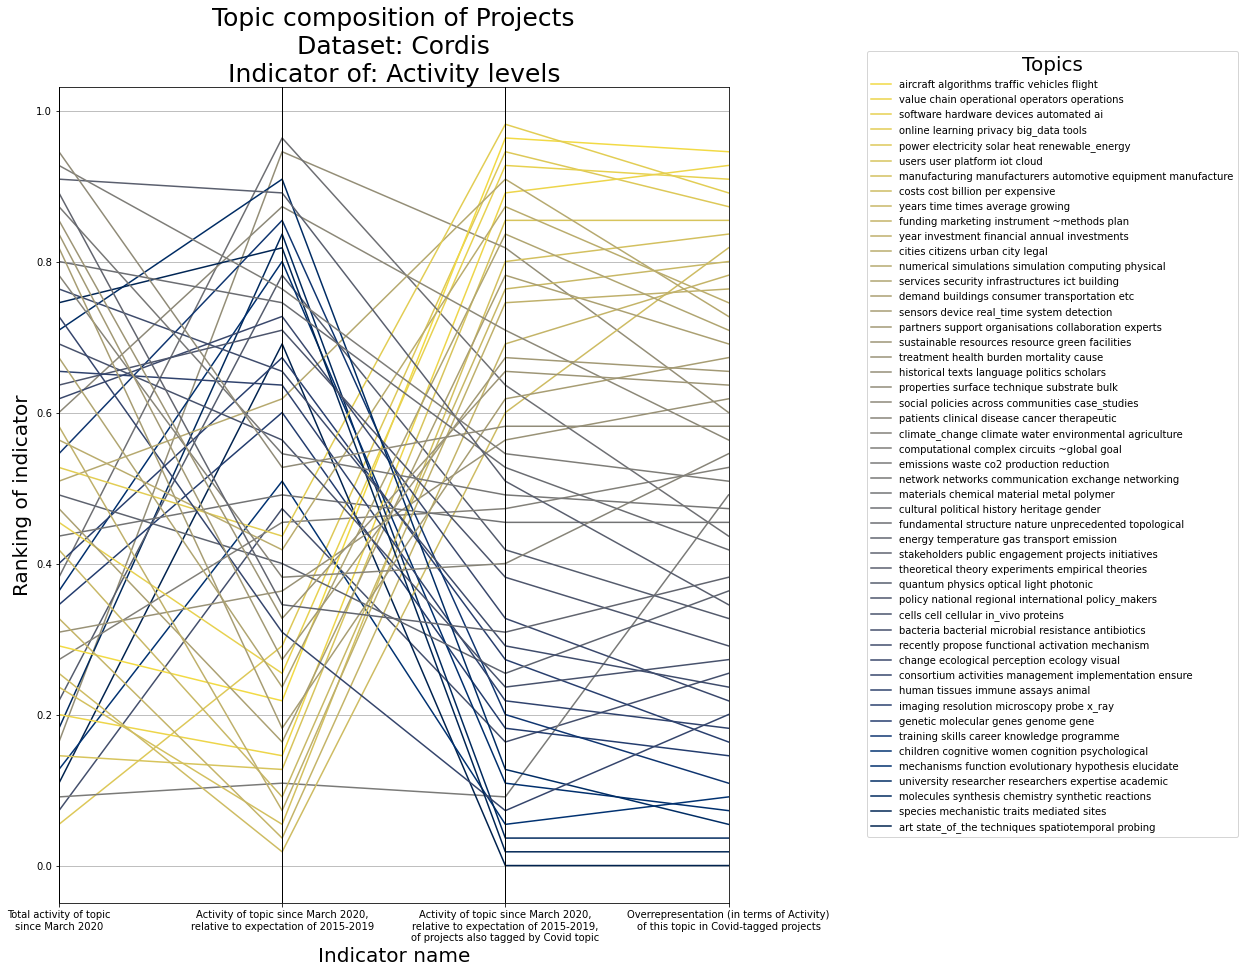

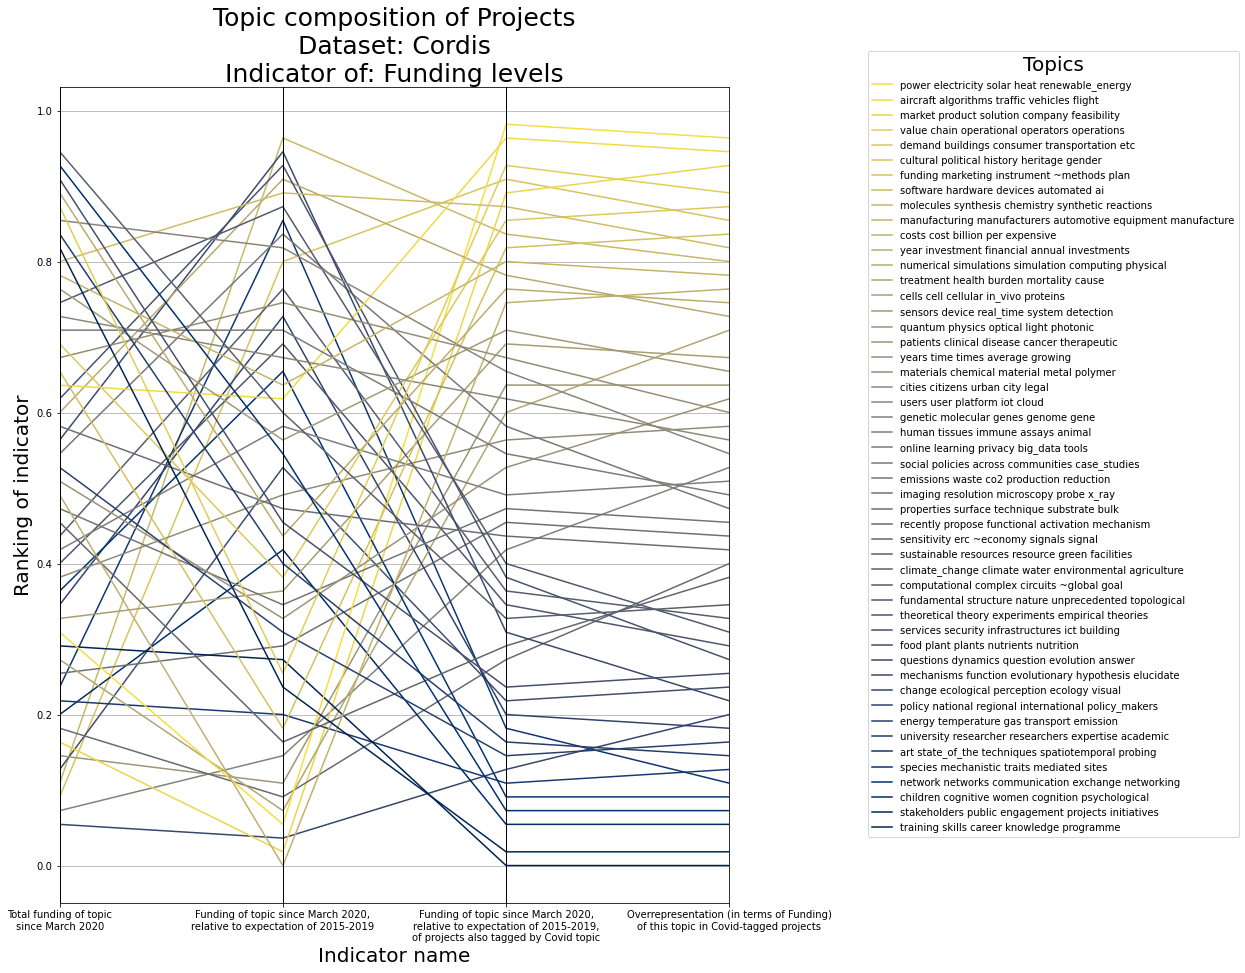

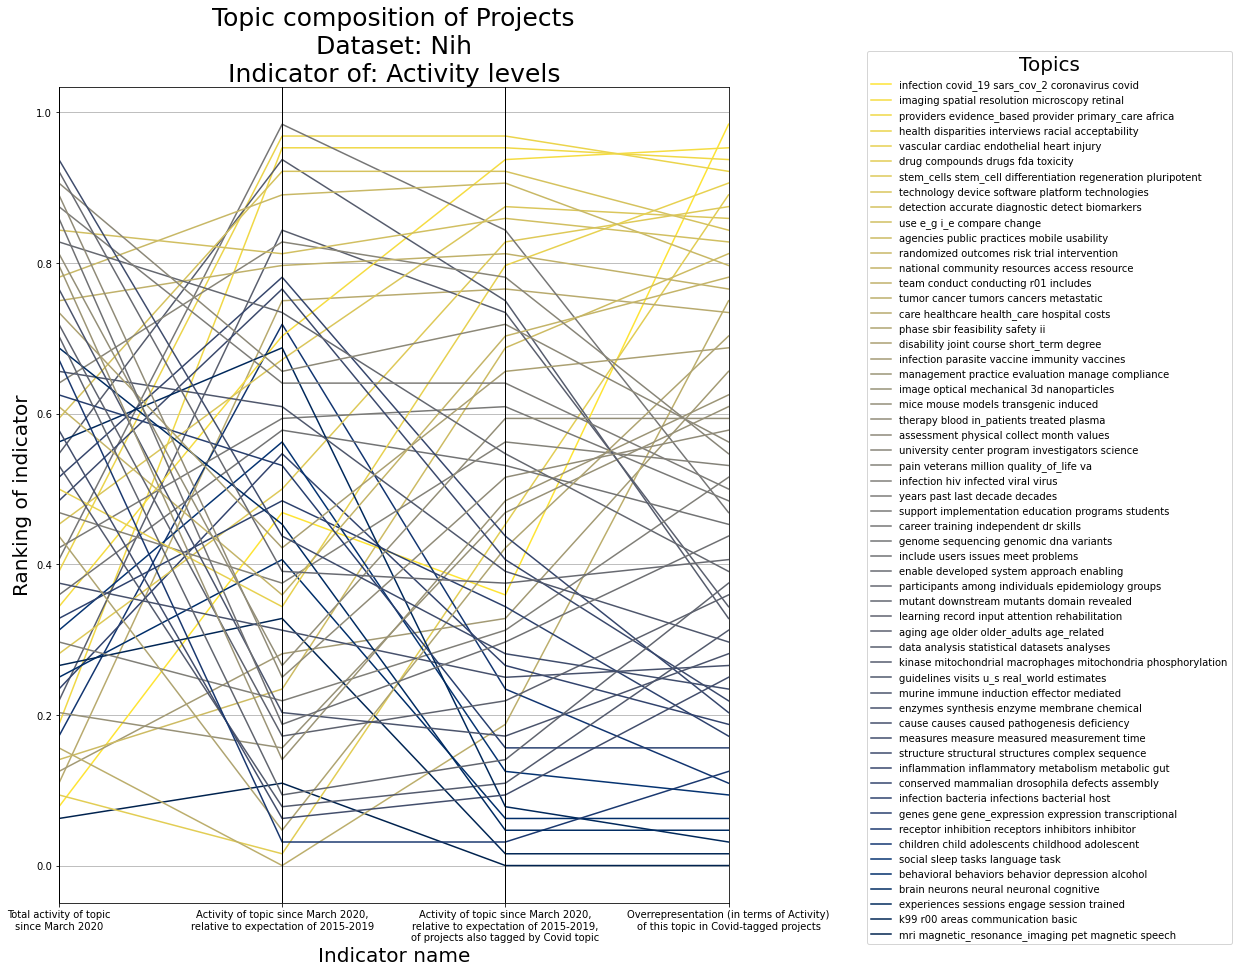

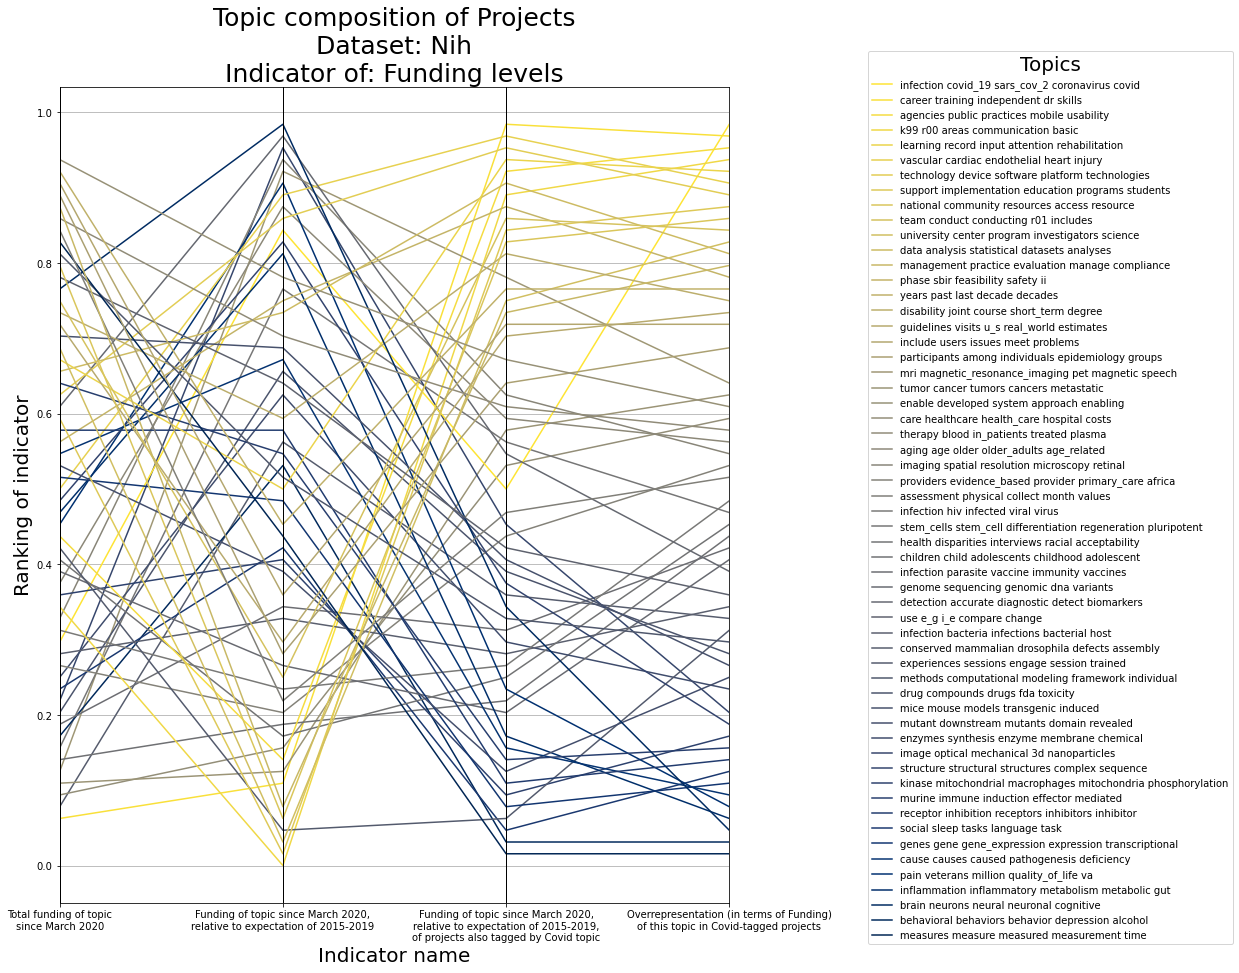

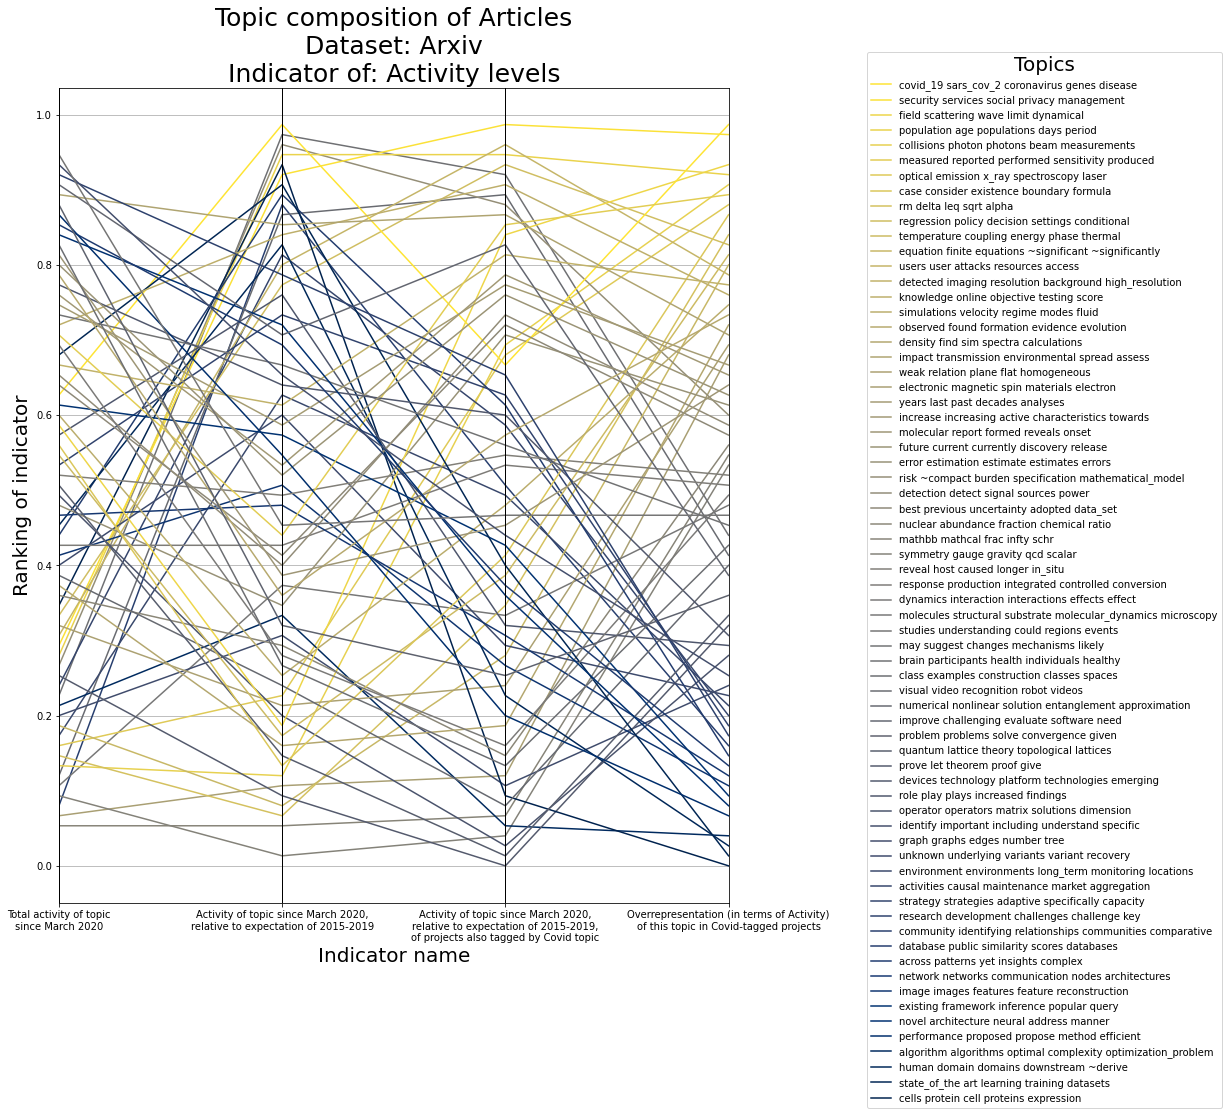

In [12]:
# Activity indicators: NiH
BASE_PATH = "/Users/jklinger/Nesta/Pivot/indicators/two/topic_iteration/topic-model-{}-100-25"
BASE_KWARGS = dict(old_from_date='2015-01-01', old_to_date='2020-01-01', covid_start='2020-03-01')

data_params = [{'dataset': 'cordis', 'entity_type': 'projects', 'data_getter': get_cordis_projects, 'datefield': 'start_date', 'weight_field':'funding'},
               #{'dataset': 'crunchbase', 'entity_type': 'organizations', 'data_getter': get_crunchbase_orgs, 'datefield': 'founded', 'weight_field':'funding'},]
               {'dataset': 'nih', 'entity_type': 'projects', 'data_getter': get_nih_projects, 'datefield': 'start_date', 'weight_field':'funding'},
               {'dataset': 'arxiv', 'entity_type': 'articles', 'data_getter': get_arxiv_articles, 'datefield': 'created', 'weight_field': None}]


diversities = {}
for params in data_params:
    weight_field = params.pop('weight_field')
    entity_type = params.pop('entity_type')
    dataset = params.pop('dataset')
    kwargs = dict(topic_model_path=BASE_PATH.format(dataset) + "/{}",
                  **BASE_KWARGS, **params)
    print("Doing", dataset)
    activity_indicators = generate_indicators(**kwargs)
    diversities[dataset] = (activity_indicators["thematic_diversity_covid"], activity_indicators["thematic_diversity_noncovid"])
    
    print("Making parallel plot")
    make_parallel_plot(activity_indicators, dataset=dataset, entity_type=entity_type)    
    if weight_field is not None:
        funding_indicators = generate_indicators(weight_field=weight_field, **kwargs)
        make_parallel_plot(funding_indicators, dataset=dataset, entity_type=entity_type, activity_type='funding')

_ = make_diversity_map(diversites)

In [ ]:
diversities